# Code to make Figure 1 - timeseries
- Decadal timeseries over entire Ross Sea for all winters
- Notebook by Alice DuVivier (NCAR)
- June 2023

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import dask
import utils
from scipy.stats import linregress,pearsonr, t, ttest_ind
import cmocean
import geopandas as gpd

## Set data info

In [2]:
# set the location of the already extracted training data
path_out = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v5/figure_code/final_figures/'
# set shape files info
fname= '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v4/USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp' 

### Load data

In [3]:
# set path to the pulled data
# Note data is for larger area than only training points
# this data has been processed all the same 'time' coordinates as training data
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'

# set what variables we can plot
var_composite_in = 'aice_d'


In [4]:
# file name for training variable only here 
fin_composite = 'antarctic_data_for_som_composites_'+var_composite_in

In [5]:
# load data
ds = xr.open_mfdataset(data_path_in+fin_composite+'.nc')

In [6]:
# explicitly load data so that it doesn't take forever later on during mean
ds = ds.load()

In [7]:
data = ds.data

### Load info with TAREA

In [8]:
# Load in the masking file
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/antarctic_ocean_masks_3.nc')


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'sh_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'socn_mask' has multiple fill values {0, -2147483647}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'Wed_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'Ross_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/glade/work

In [9]:
# rename the coordinates for the mask
ds_masks = ds_masks.rename({'nlat':'nj','nlon': 'ni'})

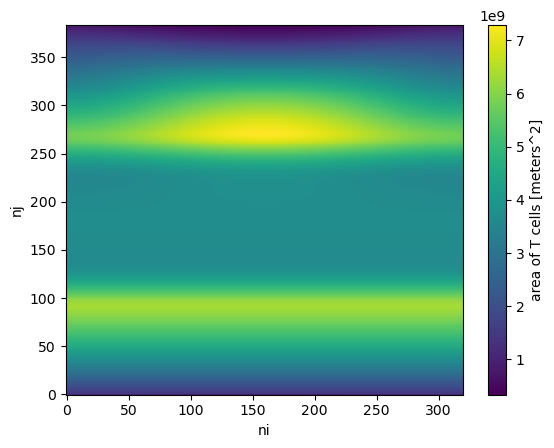

In [10]:
ds_masks.tarea.plot()

In [11]:
# set some limits for Antarctica in general
lat_max = -60
lat_min = -80

# now drop points that are masked
ds_masks_subset = ds_masks.where(((ds_masks['lat2d_T']<lat_max) & (ds_masks['lat2d_T']>lat_min)), drop=True)


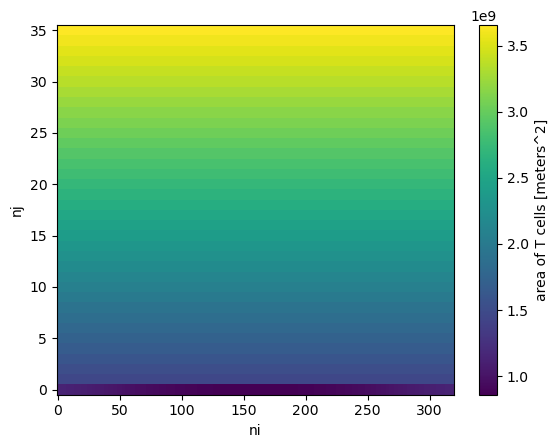

In [12]:
ds_masks_subset.tarea.plot()

In [13]:
tarea = ds_masks_subset.tarea

## Mask Ross Sector only

In [14]:
# mask outside Ross Sector
data_sub = data.where((data.TLON > 160) & (data.TLON.values < 210),drop=True)
tarea_sub = tarea.where((data.TLON > 160) & (data.TLON.values < 210),drop=True)

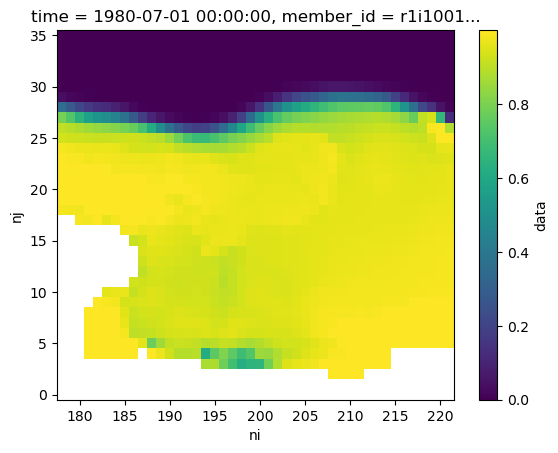

In [15]:
data_sub.isel(training_times=0).plot()

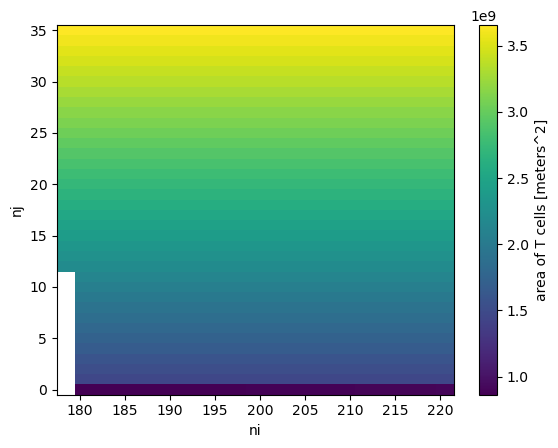

In [16]:
tarea_sub.plot()

## Calculate total ice area over this sector

In [17]:
# multiply by tarea
data_tarea = data_sub * tarea_sub

In [18]:
# divide into North and South of 75S
data_tarea_Nof75S = data_tarea.where(data_tarea.TLAT > -75)
data_tarea_Sof75S = data_tarea.where(data_tarea.TLAT <= -75)

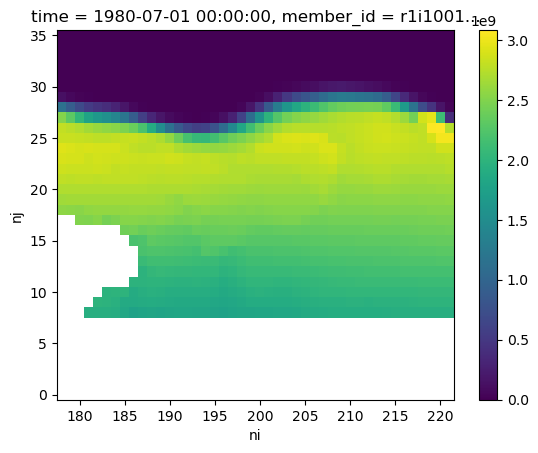

In [19]:
data_tarea_Nof75S.isel(training_times=0).plot()

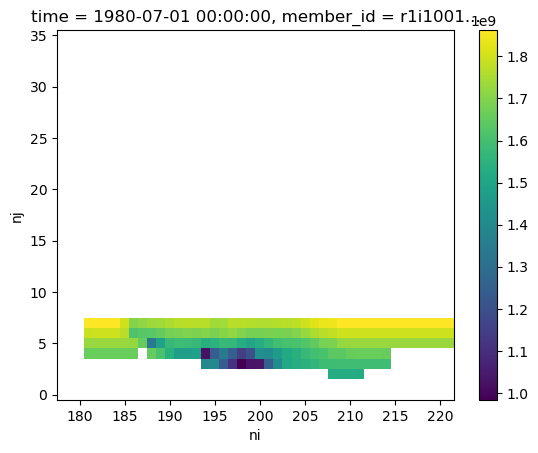

In [20]:
data_tarea_Sof75S.isel(training_times=0).plot()

In [21]:
# sum over the whole region to get total area (or volume)
total_Nof75S = data_tarea_Nof75S.sum(dim=['ni','nj'])
total_Sof75S = data_tarea_Sof75S.sum(dim=['ni','nj'])

In [22]:
# convert to km2
total_Nof75S = total_Nof75S/(1000*1000)
total_Sof75S = total_Sof75S/(1000*1000)

In [23]:
# convert to millions of km2
total_Nof75S = total_Nof75S/(10**6)
total_Sof75S = total_Sof75S/(10**6)

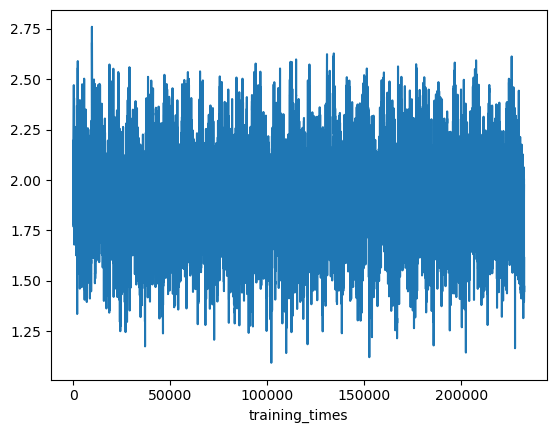

In [24]:
total_Nof75S.plot()

## Calculate the mean and standard deviations by decade for both regions

In [25]:
decade_names = ['1980','1990', '2000', '2010', '2020', '2030', '2040', '2050', '2060', '2070']

In [26]:
# make numpy array to fill and specify dimensions we want
decade_array_N = np.zeros([len(decade_names)])
stdev_array_N = np.zeros([len(decade_names)])
decade_array_S = np.zeros([len(decade_names)])
stdev_array_S = np.zeros([len(decade_names)])

for dd in decade_names:
    print('decade: '+dd+'s')
    if dd == '1980':
        d_count = 0
        yy_st = 1980
    else: 
        d_count = d_count+1
        yy_st = yy_st + 10
    # get years for this decade
    yy_ed = yy_st + 10
    yy_all = list(range(yy_st,yy_ed,1))
    # get mean and standard deviation for this decade
    decade_array_N[d_count] = total_Nof75S.isel(training_times=total_Nof75S.time.dt.year.isin([yy_all])).mean(dim='training_times')
    stdev_array_N[d_count] = total_Nof75S.isel(training_times=total_Nof75S.time.dt.year.isin([yy_all])).std(dim='training_times')
    decade_array_S[d_count] = total_Sof75S.isel(training_times=total_Sof75S.time.dt.year.isin([yy_all])).mean(dim='training_times')
    stdev_array_S[d_count] = total_Sof75S.isel(training_times=total_Sof75S.time.dt.year.isin([yy_all])).std(dim='training_times')

decade: 1980s
decade: 1990s
decade: 2000s
decade: 2010s
decade: 2020s
decade: 2030s
decade: 2040s
decade: 2050s
decade: 2060s
decade: 2070s


In [27]:
print(decade_array_N.shape)

(10,)


In [28]:
# convert numpy array to an xarray for easier plotting
decade_means_N = xr.DataArray(decade_array_N,dims=('decade'))
decade_stdev_N = xr.DataArray(stdev_array_N,dims=('decade'))
decade_means_S = xr.DataArray(decade_array_S,dims=('decade'))
decade_stdev_S = xr.DataArray(stdev_array_S,dims=('decade'))

In [29]:
# set coordinate arrays
decade_means_N['decade'] = decade_names
decade_stdev_N['decade'] = decade_names
decade_means_S['decade'] = decade_names
decade_stdev_S['decade'] = decade_names


## Calculate the linear regressions on the mean

In [30]:
# calculate linear regressions
x_in = np.linspace(1980,2070,10)   

# for North region
y_in = decade_means_N
reg_N = linregress(x_in,y_in)
rate_N = 10*reg_N.slope
r2_N = reg_N.rvalue*reg_N.rvalue
y_reg_N = (reg_N.slope*x_in)+reg_N.intercept
tx_N = 'North region rate '+str(round(rate_N,5))+' (million km2)/decade; $r^{2}$='+str(round(r2_N,2))
print(tx_N)

# for South region
y_in = decade_means_S
reg_S = linregress(x_in,y_in)
rate_S = 10*reg_S.slope
r2_S = reg_S.rvalue*reg_S.rvalue
y_reg_S = (reg_S.slope*x_in)+reg_S.intercept
tx_S = 'South region rate '+str(round(rate_S,5))+' (million km2)/decade; $r^{2}$='+str(round(r2_S,2))
print(tx_S)

North region rate -0.02866 (million km2)/decade; $r^{2}$=0.97
South region rate 0.00124 (million km2)/decade; $r^{2}$=0.97


## Make line plots of total ice area

In [31]:
# set figure name
fout = path_out+'fig_1_Ross_Sea_timeseries'

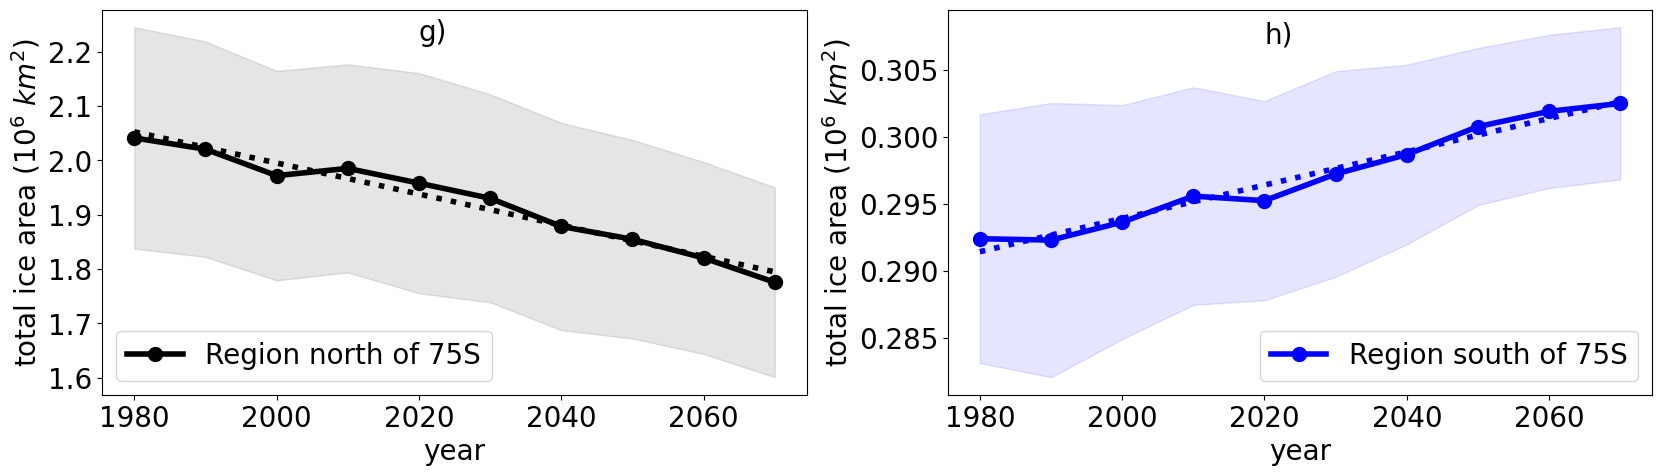

In [32]:
# create figure
fig = plt.figure(figsize=(20,5))

# array against which to plot
decades = list(range(1980,2080,10))

# Make subplots - note it's nrow x ncol x index (starting upper left)
### first subplot
ax = fig.add_subplot(1,2,1)
data = decade_means_N
under_line = decade_means_N - decade_stdev_N
over_line = decade_means_N + decade_stdev_N
# plot the mean
ax.plot(decades,data,label="Region north of 75S",color='black',linestyle='-',linewidth=4,marker='o',markersize=10)
# plot and fill between standard deviations
ax.fill_between(decades,under_line,over_line, color='black', alpha=.1)
# plot regressions
ax.plot(x_in,y_reg_N,color='black',linestyle=':',linewidth=4)
# add label
plt.text(2020,2.22,'g)', fontsize=20)
# final plot tweaks    
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('total ice area (10$^6$ $km^{2}$)',fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower left', fontsize=20);

### second subplot
ax = fig.add_subplot(1,2,2)
data = decade_means_S
under_line = decade_means_S - decade_stdev_S
over_line = decade_means_S + decade_stdev_S
# plot the mean
ax.plot(decades,data,label="Region south of 75S",color='blue',linestyle='-',linewidth=4,marker='o',markersize=10)
# plot and fill between standard deviations
ax.fill_between(decades,under_line,over_line, color='blue', alpha=.1)
# plot regressions
ax.plot(x_in,y_reg_S,color='blue',linestyle=':',linewidth=4)
# add label
plt.text(2020,0.307,'h)', fontsize=20)
# final plot tweaks    
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('total ice area (10$^6$ $km^{2}$)',fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower right', fontsize=20);
    
# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
